# **IV-RV Mispricing**

The IV–RV spread refers to the gap between **implied volatility (IV)**, which reflects the market’s expectation of future variance, and **realized volatility (RV)**, which measures the actual variance observed in past returns. On average, IV tends to exceed RV because option sellers demand compensation for bearing tail risk and for taking the other side of persistent hedging flows. This difference is known as the **Variance Risk Premium (VRP)**.  

## Why Trade the IV–RV Spread?

While the VRP exists structurally, it is **time-varying** and can deviate significantly from fair value.  
- In calm markets, IV may remain elevated relative to RV, leading to overpriced options.  
- After shocks or during regime shifts, IV may lag realized outcomes and even understate true risk.  

By forecasting RV with historical and high-frequency data, traders can identify periods when the IV–RV spread is abnormally wide or inverted. Trading these dislocations through delta-hedged long or short volatility positions allows us to selectively capture the VRP while avoiding its most dangerous drawdowns.  

As options traders, we are not merely collecting the variance risk premium passively, we are exploiting **mispricings in its dynamics**, aiming for superior risk-adjusted returns by timing when IV is too rich or too cheap relative to expected realized volatility.  


The notebook is structured as follows:

1. [Read daily SPX Options chain & intraday SPX Index](#read_data)
2. [The Variance Risk Premium (VRP) — Stylized Facts](#plot_vrp)
    - VRP > 0 in average -> on avarge selling vol is more profitable than buying vol -> this is our edge
    - VRP distribution is left skewed -> high nb of small proiftable trades but large ocasional losses -> 
    avoid selling voll in market distress
    - Mean reverting VRP -> when VRP is very negaitve it tends to mean revert rapdily i.e. the RV drops and the IV stays elevated -> long vol
    - Say that for this notebook we are going to levrage the first two syl fatcs by selling the vol but conditon it on the regime.
    Say that Mean(VRP) > 0 is our edge by plottign across VIX bukcets and across other horizons, also mention it is well comuenetd and also present across msot asset classes (single stocks, commodity, currency, VIX futures ...)

    - Can alos do a MC to show the P&L for a short straddle and short strangle stategy and show the Eexpetc profit and the large left tails
    and comapre with the P&L distrbution from a short butterfly / ironcondor startegy and say how durign volaility regimes it can prevent huge losses but at teh cost of incerased transaction cost, show also the way of chhosing teh strikes for for butterfly usign delta as strike selection vs IV.

    Put the P&L equation from BS

2. [Simple Regime Model](#plot_vrp)
    [## 9.5 Motivation for regime conditioning]()
        - VRP regime shifts post-2018
        - IV more accurate than RV at short horizons
        - Why raw strategy fails in crises -> show teh perfromacne of SP500 vs XIV ETN and show why need regime filter

    - Present the lagged VRP z score and the IVP, bucket on the true VRP and show the regimes when the VRP is the highest and the ones it is bad to sell vol
    - Show that since lagged VRP z score is lagged (because of teh mean reversion of RV), we prefer the IVP as a regime indicator
    where we scale our psotion differently across buckets.
    The IVP is thus our main regime trading indicator

3. [Add extra Trading Tail Risk-Filters / Confirmation Signals)]()
    - Used to reduce the nb of false positive by providing high quality trades and to reduce the tail risk
    We need use boht regime filter and regime switching filter (like VVIX) to avoid tradign when goign from normal to panick regime.

    Tail Risk-Filters: 
    - VIX level: dont sell vol when VIX > 30
    - VIX TS: Dont sell vol when VIX > VIX3M or VIX9D > VIX, or form the IV surface diretclty for short horizo
    - Moving avarge crossover of IV or VIX to detetc swithing vol regimes -> can probably optimize them
    - vol-of-vol/momentum of VIX (VIX spikes): Dont sell when VVIX > 120 or dVIX/dt > 10% (Large VIX spikes often cluster — this filter protects during regime shifts.)
    
    - SKEW Index: dont sell vol when CBOE SKEW > 140 and/or dSKEW /dt > 10%
    - Trend / Momentum Filters (SPX Price): Momentum negative → stay out, Price < 200-day -> do,t sell vol
    - Macro Filters: Terme strcuture, credit spread, dont sell vol when YIELD curve inveretd or the credit spread widens a lot
    (optional but still relevant for our 30d horizon and also because for SPX it is also relevant to such macro shocks)

    Check for the rollign correlation between the fliters over time, chekc how they perform across eahc vol regime givne by IVP, 
    how they perform in low VIX environvemenbt vs mediumvs high VIX.

    Sell a short straddle, but if the risk is rising, maybe instead go short a butterfly or if currently in an opneend starddle buy OTM calls and puts or exit the position prematuraly.

    In the trade when rsik strats to rise, either close the trade (VIX TS inversion) or for larger contracts reduc ethe size (if 2 contratcs sell one) or buy OTM Calls and Puts of teh same matruity as current starddle, or can use a trailing stop loss and makign it at the current level if the trade is currently positive. Maybe adapt the startegy to teh current position, if risk rises and currently losign then maybe close the trade now, if currently in a winign trade set a lower stop loss or use a trailing stop loss to teh current profit level. 

Perform a backtets in this reserahc period in sample and do a stability analysis of trading parameters to verify that the strategy is 
robsut across different paraemetr values and it should be else it would indicate the stratgey is not good.

6. [Realistic Backtest with walk forward & Risk management](#plot_iv)  
7. [Conclusion](#plot_iv)  

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import skew, kurtosis

from volatility_trading.iv_surface.svi_model import SVI
import volatility_trading.strategies.vrp_mispricing.plotting as ph
from volatility_trading.rv_forecasting.features import create_forward_target

from config.paths import DATA_INTER, DATA_PROC

import volatility_trading.rv_forecasting.features as rvfeat
import volatility_trading.rv_forecasting.vol_estimators as rvvol
from volatility_trading.rv_forecasting.data_loading import load_intraday_prices

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# **1. Read SPX Options Data**

In this notebook we are going to consider the entire options chain, namely all strikes and expiries for each date in the year `2023`.

In [2]:
file = DATA_INTER / "full_spx_options_2016_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_iv", "p_iv",
]

options = pd.read_parquet(file, columns=cols)
spot = options.groupby("date")["underlying_last"].first()

options["T"] = options["dte"] / 252
options["k"] = np.log(options["strike"] / options["underlying_last"])
options

,strike,underlying_last,dte,expiry,c_iv,p_iv,T,k
date,,,,,,,,
2016-01-04,300.0,2012.98,4.0,2016-01-08,NaN,4.66805,0.015873,-1.903589
2016-01-04,400.0,2012.98,4.0,2016-01-08,NaN,3.96379,0.015873,-1.615907
2016-01-04,500.0,2012.98,4.0,2016-01-08,NaN,3.42696,0.015873,-1.392763
2016-01-04,600.0,2012.98,4.0,2016-01-08,NaN,2.98443,0.015873,-1.210442
2016-01-04,700.0,2012.98,4.0,2016-01-08,NaN,2.61505,0.015873,-1.056291
...,...,...,...,...,...,...,...,...
2023-12-29,7200.0,4772.17,2184.0,2029-12-21,0.17401,NaN,8.666667,0.411280
2023-12-29,7400.0,4772.17,2184.0,2029-12-21,0.17063,NaN,8.666667,0.438679
2023-12-29,7600.0,4772.17,2184.0,2029-12-21,0.16688,NaN,8.666667,0.465347


# **3. The Variance Risk Premium (VRP) — Stylized Facts**

Here we investigate the *stylized facts* — the key statistical properties of the VRP that can be modeled and potentially exploited for trading strategies.

### **Extract the interpolated 30D ATM IV for each day**

Since we don’t always observe an option with exactly 30 days to expiry, we fit an IV surface and interpolate in **total variance space** between the two closest ATM maturities bracketing 30 DTE.

In [2]:
iv_atm = pd.read_csv(DATA_PROC / "spx_atm_iv_30d_2010_2020.csv", index_col=0, parse_dates=True)
iv_atm *= 100

In [3]:
import yfinance as yf
vix = yf.download('^VIX', start="2010-01-01", end="2023-12-31")["Close"]
vix = vix.rename(columns={"^VIX": "VIX"})
vix = vix["VIX"].squeeze()

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_3091/1063496669.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start="2010-01-01", end="2023-12-31")["Close"]
[*********************100%***********************]  1 of 1 completed


### **Compute the 21-Day Realized Volatility**

We calculate **realized volatility** over a rolling **21-trading-day** window (which is approx 30 calendar days) using the underlying’s daily returns. This measure is annualized and represents the actual volatility observed over the past month, which will be compared to the 30-DTE implied volatility.

In [ ]:
H = 21
es_5min = load_intraday_prices(DATA_INTER / "es-5m.csv", start="2010", end="2023")

# COmpute the annualized realized volaitlity
rv_real = np.sqrt(np.exp(create_forward_target(daily_rv, horizon=H)) * 252).rename('rv_true')
rv_real *= 100
rv_real_lag = rv_real.shift(21).rename("rv_lag")

In [5]:
vol = pd.concat([rv_real, rv_real_lag, iv_atm, vix], axis=1).dropna()

### **Compute the Variance Risk Prenium (VRP)**

In [11]:
vol["vrp_true"] = vol["iv_atm"] - vol["rv_true"]
vol["vrp_lag"] = vol["iv_atm"] - vol["rv_lag"]
vol["vrp_true_vix"] = vol["VIX"] - vol["rv_true"]

In [7]:
window = 252

# Z score VRP
mu = vol["vrp_lag"].rolling(window).mean().shift(1)
sigma = vol["vrp_lag"].rolling(window).std().shift(1)
vol['z_score_vrp'] = (vol["vrp_lag"]  - mu) / sigma

## **3.1 Stylized facts 1 & 2: Positive and time-varying VRP**

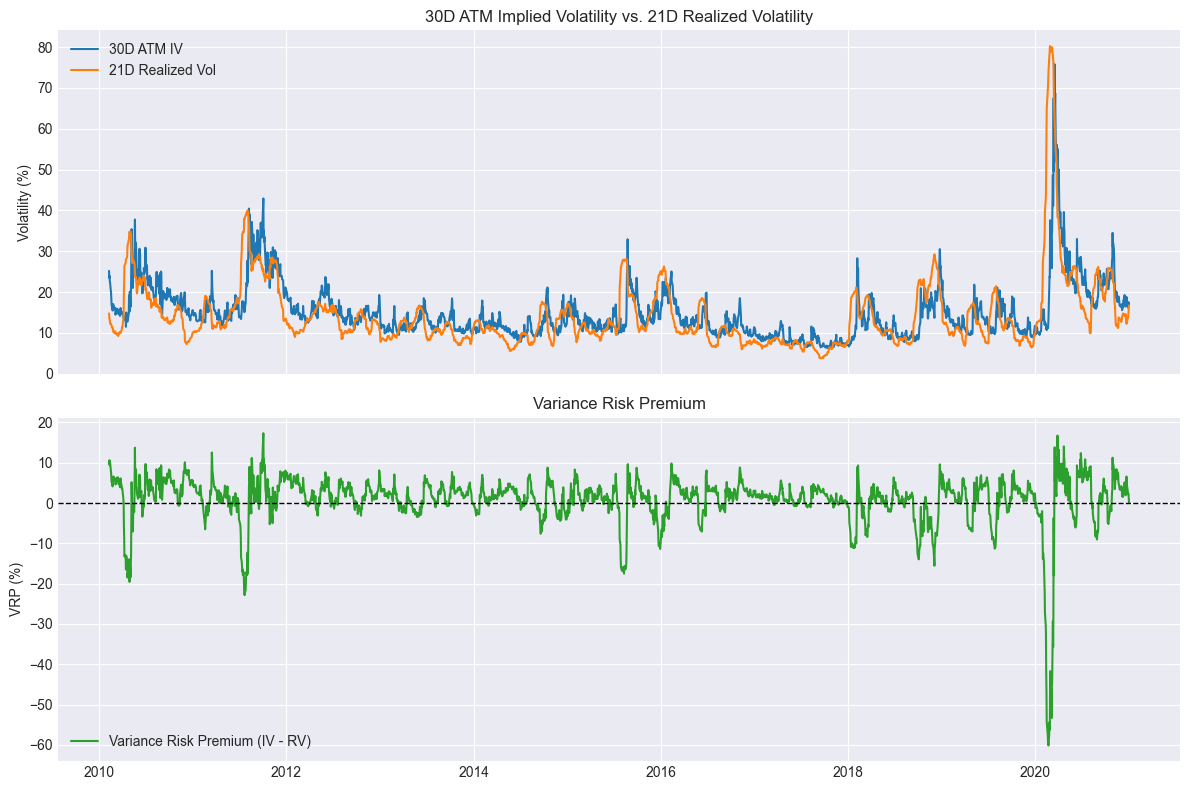

In [8]:
ph.plot_vrp(vol.loc["2010":, "iv_atm"], vol.loc["2010":, "rv_true"], vol.loc["2010":, "vrp_true"])

During calm markets, the VRP is typically positive, whereas during crashes (e.g., the COVID-19 lockdown) realized volatility can exceed implied volatility when the market fails to anticipate the shock. It migth sugguest that a strategy consiting in selling preniums can be profitabel over the long run.

In [14]:
bins = [-np.inf, -1.0, -0.5, 0.5, 1.0, np.inf]
labels = ["very_low", "low", "mid", "high", "very_high"]

vol["z_bucket"] = pd.cut(vol["z_score_vrp"], bins=bins, labels=labels)

grouped = vol.groupby("z_bucket")["vrp_true"].agg(["mean", "std", "count"])
grouped

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_3092/4210476824.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = vol.groupby("z_bucket")["vrp_true"].agg(["mean", "std", "count"])


,mean,std,count
z_bucket,,,
very_low,1.223956,7.078972,404
low,-0.969162,9.507876,252
mid,0.472657,5.252106,1070
high,0.739427,5.031470,476
very_high,1.210471,8.341736,267


In [19]:
vol = vol.loc[:"2018"]

In [21]:
bins = [-np.inf, 15, 20, 30, np.inf]

labels = [
    "15 <= VIX",
    "15 < VIX <= 20",
    "20 < VIX <= 30",
    "VIX >= 30",
]

vol["vix_bucket"] = pd.cut(vol["VIX"], bins=bins, labels=labels)

grouped = vol.groupby("vix_bucket")["vrp_true"].agg(["mean", "std", "max", "min", "skew", "count"])
grouped

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_2218/190678729.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol["vix_bucket"] = pd.cut(vol["VIX"], bins=bins, labels=labels)
/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_2218/190678729.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = vol.groupby("vix_bucket")["vrp_true"].agg(["mean", "std", "max", "min", "skew", "count"])


,mean,std,max,min,skew,count
vix_bucket,,,,,,
15 <= VIX,0.336446,3.530355,5.902433,-17.526195,-2.503413,1020
15 < VIX <= 20,1.027342,5.037364,8.757357,-22.860830,-1.927878,728
20 < VIX <= 30,2.154742,5.695000,12.531410,-21.542589,-1.572812,371
VIX >= 30,3.828693,4.921040,17.310865,-16.508218,-0.551213,105


In [9]:
def compute_iv_percentile(iv_series, window=252):
    def _iv_percentile(x):
        x = x[~np.isnan(x)]          # drop NaNs inside the window
        if len(x) == 0:
            return np.nan
        current = x[-1]
        return np.mean(x <= current) # fraction of window <= current
    return iv_series.rolling(window=window).apply(_iv_percentile, raw=True)

vol['ivp'] = compute_iv_percentile(vol['iv_atm'])

bins = [0.0, 0.2, 0.5, 0.8, 0.9, 0.95, 1]

labels = [
    "0 <= IVP < 0.3",
    "0.3 <= IVP < 0.5",
    "0.5 ≤ IVP < 0.8",
    "0.8 ≤ IVP < 0.9",
    "0.9 ≤ IVP < 0.95",
    "0.95 ≤ IVP < 1"
]

vol["ivp_bucket"] = pd.cut(vol["ivp"], bins=bins, labels=labels)

grouped = vol.groupby("ivp_bucket")["vrp_true"].agg(["mean", "std", "count"])
grouped

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_3091/3410001825.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = vol.groupby("ivp_bucket")["vrp_true"].agg(["mean", "std", "count"])


,mean,std,count
ivp_bucket,,,
0 <= IVP < 0.3,0.766195,2.663419,642
0.3 <= IVP < 0.5,0.014044,6.186726,691
0.5 ≤ IVP < 0.8,0.990086,6.329956,662
0.8 ≤ IVP < 0.9,1.799686,5.757482,194
0.9 ≤ IVP < 0.95,0.378352,6.448783,110
0.95 ≤ IVP < 1,-0.705413,14.251498,171


In [12]:
def compute_iv_percentile(iv_series, window=252):
    def _iv_percentile(x):
        x = x[~np.isnan(x)]          # drop NaNs inside the window
        if len(x) == 0:
            return np.nan
        current = x[-1]
        return np.mean(x <= current) # fraction of window <= current
    return iv_series.rolling(window=window).apply(_iv_percentile, raw=True)

vol['ivp'] = compute_iv_percentile(vol['VIX'])

bins = [0.0, 0.2, 0.5, 0.8, 0.9, 0.95, 1]

labels = [
    "0 <= IVP < 0.3",
    "0.3 <= IVP < 0.5",
    "0.5 ≤ IVP < 0.8",
    "0.8 ≤ IVP < 0.9",
    "0.9 ≤ IVP < 0.95",
    "0.95 ≤ IVP < 1"
]

vol["ivp_bucket"] = pd.cut(vol["ivp"], bins=bins, labels=labels)

grouped = vol.groupby("ivp_bucket")["vrp_true_vix"].agg(["mean", "std", "count"])
grouped

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_3091/3818307676.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = vol.groupby("ivp_bucket")["vrp_true_vix"].agg(["mean", "std", "count"])


,mean,std,count
ivp_bucket,,,
0 <= IVP < 0.3,2.856340,3.110850,646
0.3 <= IVP < 0.5,3.114693,5.830340,666
0.5 ≤ IVP < 0.8,3.829481,6.309471,702
0.8 ≤ IVP < 0.9,5.061116,8.017529,181
0.9 ≤ IVP < 0.95,4.677508,6.645505,124
0.95 ≤ IVP < 1,4.206887,15.057197,151


In [ ]:
def compute_iv_percentile(iv_series, window=252):
    def _iv_percentile(x):
        x = x[~np.isnan(x)]          # drop NaNs inside the window
        if len(x) == 0:
            return np.nan
        current = x[-1]
        return np.mean(x <= current) # fraction of window <= current
    return iv_series.rolling(window=window).apply(_iv_percentile, raw=True)

vol['ivp'] = compute_iv_percentile(vol['VIX'])

bins = [0.0, 0.2, 0.5, 0.8, 0.9, 0.95, 1]

labels = [
    "0 <= IVP < 0.3",
    "0.3 <= IVP < 0.5",
    "0.5 ≤ IVP < 0.8",
    "0.8 ≤ IVP < 0.9",
    "0.9 ≤ IVP < 0.95",
    "0.95 ≤ IVP < 1"
]

vol["ivp_bucket"] = pd.cut(vol["ivp"], bins=bins, labels=labels)

grouped = vol.groupby("ivp_bucket")["vrp_true"].agg(["mean", "std", "count"])
grouped

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_3091/477630060.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = vol.groupby("ivp_bucket")["vrp_true"].agg(["mean", "std", "count"])


,mean,std,count
ivp_bucket,,,
0 <= IVP < 0.3,0.469657,3.076822,646
0.3 <= IVP < 0.5,0.539031,5.711160,666
0.5 ≤ IVP < 0.8,0.730837,6.269389,702
0.8 ≤ IVP < 0.9,1.345305,7.456784,181
0.9 ≤ IVP < 0.95,0.965447,6.095074,124
0.95 ≤ IVP < 1,-0.738317,14.942553,151


In [ ]:
def compute_iv_percentile(iv_series, window=252):
    def _iv_percentile(x):
        x = x[~np.isnan(x)]          # drop NaNs inside the window
        if len(x) == 0:
            return np.nan
        current = x[-1]
        return np.mean(x <= current) # fraction of window <= current
    return iv_series.rolling(window=window).apply(_iv_percentile, raw=True)

vol['ivp'] = compute_iv_percentile(vol['iv_atm'])

bins = [0.0, 0.5, 0.8, 0.9, 0.95, 1]

labels = [
    "0 <= IVP < 0.5",
    "0.5 ≤ IVP < 0.8",
    "0.8 ≤ IVP < 0.9",
    "0.9 ≤ IVP < 0.95",
    "0.95 ≤ IVP < 1"
]

vol["ivp_bucket"] = pd.cut(vol["ivp"], bins=bins, labels=labels)

grouped = vol.groupby("ivp_bucket")["vrp_true"].agg(["mean", "std", "count"])
grouped

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_3092/3300132689.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = vol.groupby("ivp_bucket")["vrp_true"].agg(["mean", "std", "count"])


,mean,std,count
ivp_bucket,,,
0 <= IVP < 0.5,0.376295,4.835550,1333
0.5 ≤ IVP < 0.8,0.990086,6.329956,662
0.8 ≤ IVP < 0.9,1.799686,5.757482,194
0.9 ≤ IVP < 0.95,0.378352,6.448783,110
0.95 ≤ IVP < 1,-0.705413,14.251498,171


If 0.9 < IVP < 0.95 sell a butterfly to hedge risk.

In [ ]:
bins = [
    0.0,
    0.5,
    0.9,
    1
]

labels = [
    "0 <= z < 0.5",
    "0.5 ≤ z < 0.9",
    "0.9 ≤ z < 1"
]

,rv_true,rv_lag,iv_atm,VIX,vrp_true,vrp_lag,z_score_vrp
rv_true,1.000000,0.563970,0.668117,0.668582,-0.648929,-0.101851,-0.062122
rv_lag,0.563970,1.000000,0.863021,0.866382,0.131221,-0.659318,-0.514391
iv_atm,0.668117,0.863021,1.000000,0.989471,0.132554,-0.189187,-0.101498
VIX,0.668582,0.866382,0.989471,1.000000,0.121168,-0.211391,-0.109249
vrp_true,-0.648929,0.131221,0.132554,0.121168,1.000000,-0.057780,-0.020281
vrp_lag,-0.101851,-0.659318,-0.189187,-0.211391,-0.057780,1.000000,0.860647
z_score_vrp,-0.062122,-0.514391,-0.101498,-0.109249,-0.020281,0.860647,1.000000


In [21]:
vol["vix_ret"] = vol["VIX"].pct_change(1).shift(-1)

In [23]:
vol[["z_score_vrp", "vix_ret"]].corr()

,z_score_vrp,vix_ret
z_score_vrp,1.00000,-0.03876
vix_ret,-0.03876,1.00000


<Axes: xlabel='z_score_vrp', ylabel='vix_ret'>

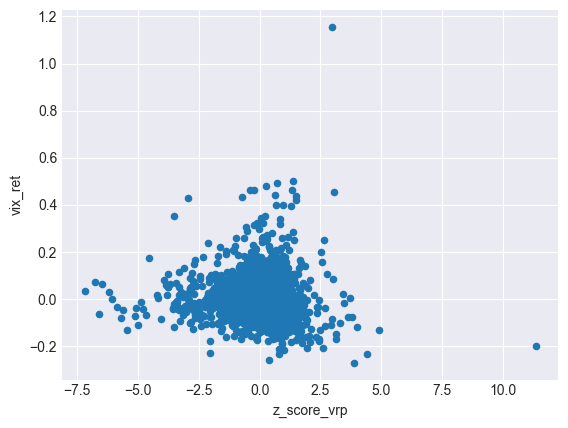

In [22]:
vol[["z_score_vrp", "vix_ret"]].plot(kind="scatter", y="vix_ret", x="z_score_vrp")

<Axes: >

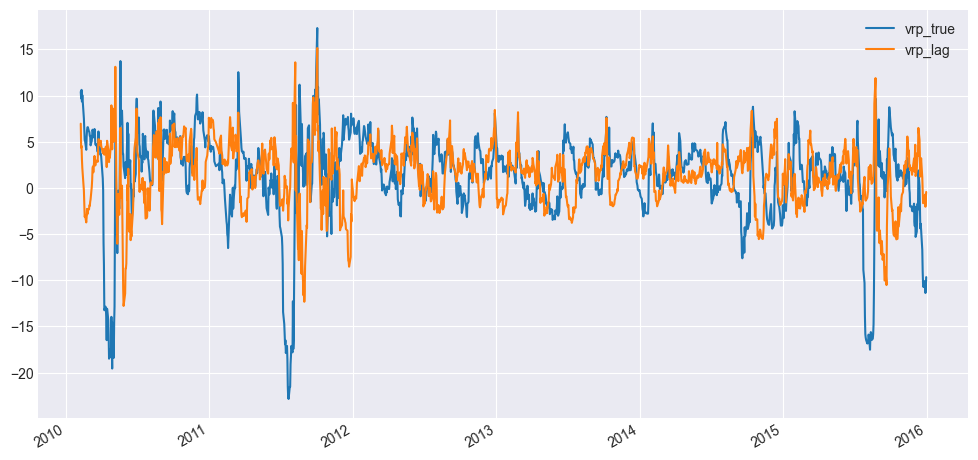

In [44]:
vol.loc[:"2015", ["vrp_true", "vrp_lag"]].plot(figsize=(12, 6))

In [65]:
print("Before 2018:", vrp_30d.loc["2010":"2017"].mean())

Before 2018: 4.104989527212386


In [66]:
print("After 2018", vrp_30d.loc["2018":].mean())
print("After Covid", vrp_30d.loc["2020":].mean())

After 2018 3.70591176482657
After Covid 4.200582275324071


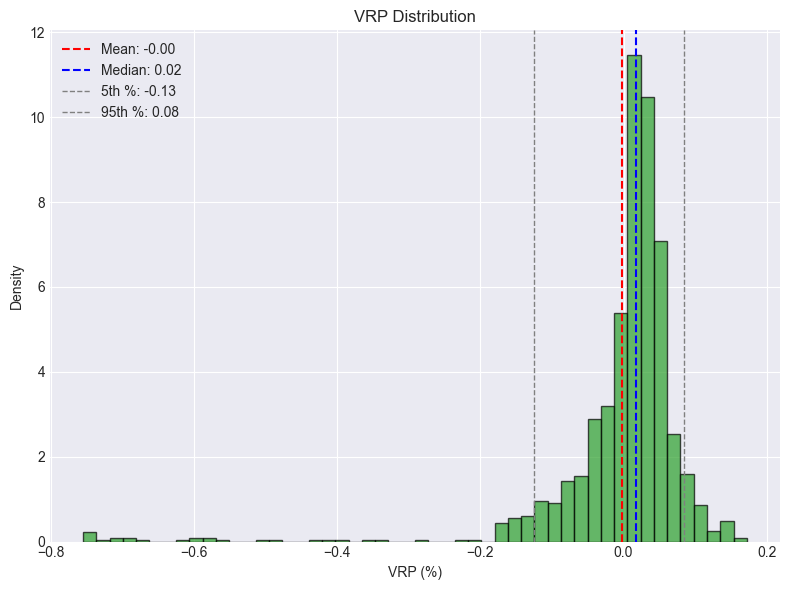

In [13]:
ph.plot_vrp_hist(vrp_30d)

In [14]:
vrp_30d.loc["2020":].mean()

np.float64(-0.030462966949666694)

In [15]:
print("Skewness VRP:", round(skew(vrp_30d.dropna()), 2))
print("Excess Kurtosis VRP:", round(kurtosis(vrp_30d.dropna()), 2))

Skewness VRP: -4.5
Excess Kurtosis VRP: 26.63


This sugguets that despite VRP beign mostly positive due to IV > RV, durign market crashes the RV >> IV leading to substancial losses. This migth sugguets that a tight risk control is necessary to prevent losses when selling preniums.

## **3.3 Stylized facts 4 & 5: Mean-reversion and Persistence**

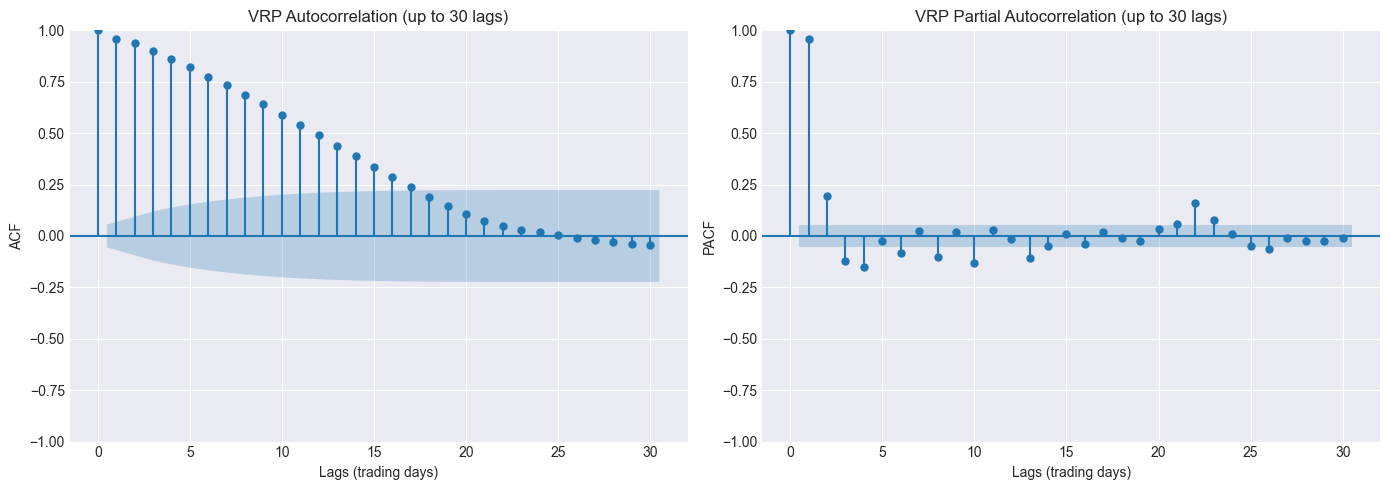

In [16]:
ph.plot_vrp_autocorr(vrp_30d, lags=30)

ACF decayign toward s0 like and PACF meaning different from 0 onyl for some lags is a typical behviour in AR-mean revrting processes.

In [17]:
def fit_ar1_vrp(vrp):
    vrp = vrp.dropna()
    
    # Fit AR(1) model
    model = AutoReg(vrp, lags=1, old_names=False)
    res = model.fit()
    
    phi = res.params['y.L1']
    intercept = res.params['const']
    
    # Half-life calculation for mean reversion
    if phi < 1:
        halflife = -np.log(2) / np.log(abs(phi))
    else:
        halflife = np.inf
    
    print(res.summary())
    print(f"\nAR(1) coefficient (phi): {phi:.4f}")
    print(f"Half-life: {halflife:.2f} days")
    return res

# Example usage
res = fit_ar1_vrp(vrp_30d)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1250
Model:                     AutoReg(1)   Log Likelihood                2672.322
Method:               Conditional MLE   S.D. of innovations              0.028
Date:                Mon, 17 Nov 2025   AIC                          -5338.644
Time:                        18:26:37   BIC                          -5323.254
Sample:                             1   HQIC                         -5332.858
                                 1250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.773e-05      0.001     -0.034      0.973      -0.002       0.002
y.L1           0.9599      0.008    121.231      0.000       0.944       0.975
                                    Roots           

/Users/anthony/miniforge3/envs/volatility_trading/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


A p-value less than 1% sugguets that the VRP has mean reverting properties whihc can be used in a **stat-arb context**.

```python
if (VIX > 20 and VIX > VIX_roll_mean5d and VIX 5d change > +10%) or VIX > 30:
    signal = False
```